In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, log_loss, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import time

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 1. data
d = pd.read_excel('YOUR DATA PATH')
X = d.drop(columns=["Class"])
y = d["Class"]
feature_names = X.columns.tolist() 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 9527 Test size: 4084


In [3]:
# 2. models & hyper-parameters
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, penalty="l2"),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "GaussianNB": GaussianNB(),
}

parameters_grid = {
    "Logistic Regression": {
        "model__C": [0.1, 1, 5, 10],
        "model__solver": ["lbfgs","newton-cg"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11, 15],
        "model__p": [1, 2],
        "model__weights": ["uniform", "distance"]
    },
    "SVM": {
        "model__C": [0.1, 1, 5, 10],
        "model__gamma": ["auto", 0.01, 0.001],
        "model__kernel": ["rbf"]
    },
    "GaussianNB": {
        "model__var_smoothing": [1e-9, 1e-8, 1e-7]
    }
}

In [8]:
# train & evaluate
fitted_models = {}
rows=[]

for name, clf in base_models.items():
    print("=" * 70)
    print(f"# Model: {name}")

    # GridSearch
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf),
    ])

    grid = GridSearchCV(
        pipe,
        parameters_grid[name],
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
    )

    grid.fit(X_train, y_train)

    print("Best parameters:", grid.best_params_)
    print(f"Best CV macro-F1: {grid.best_score_:.8f}")

    best_clf = clf.__class__(**{
        k.replace("model__", ""): v
        for k, v in grid.best_params_.items()
    })

    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", best_clf),
    ])

    # training time
    t0 = time.perf_counter()
    best_model.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # prediction time
    t0 = time.perf_counter()
    y_pred = best_model.predict(X_test)
    pred_time = time.perf_counter() - t0

    acc = accuracy_score(y_test, y_pred)

    print(f"Train time: {train_time:.4f}s | Predict time: {pred_time:.6f}s")
    print(f"Test set accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    fitted_models[name] = best_model

# Model: Logistic Regression
Best parameters: {'model__C': 5, 'model__solver': 'lbfgs'}
Best CV macro-F1: 0.93710866


/Users/angelye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train time: 0.2503s | Predict time: 0.004617s
Test set accuracy: 0.9219
Classification report:
              precision    recall  f1-score   support

    BARBUNYA     0.9493    0.8967    0.9223       397
      BOMBAY     1.0000    1.0000    1.0000       157
        CALI     0.9371    0.9448    0.9409       489
    DERMASON     0.9234    0.9060    0.9146      1064
       HOROZ     0.9634    0.9567    0.9601       578
       SEKER     0.9366    0.9474    0.9419       608
        SIRA     0.8438    0.8812    0.8621       791

    accuracy                         0.9219      4084
   macro avg     0.9362    0.9333    0.9346      4084
weighted avg     0.9227    0.9219    0.9221      4084

# Model: KNN
Best parameters: {'model__n_neighbors': 15, 'model__p': 2, 'model__weights': 'distance'}
Best CV macro-F1: 0.93708265
Train time: 0.0094s | Predict time: 0.064641s
Test set accuracy: 0.9209
Classification report:
              precision    recall  f1-score   support

    BARBUNYA     0.9699    


Permutation importance: Logistic Regression (START)
Permutation importance: Logistic Regression (DONE)

Permutation importance: Logistic Regression


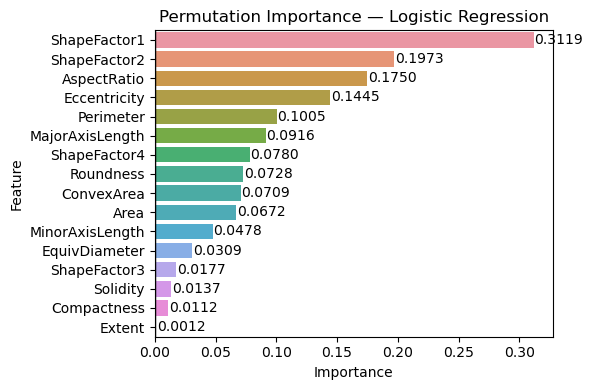


Permutation importance: KNN (START)
Permutation importance: KNN (DONE)

Permutation importance: KNN


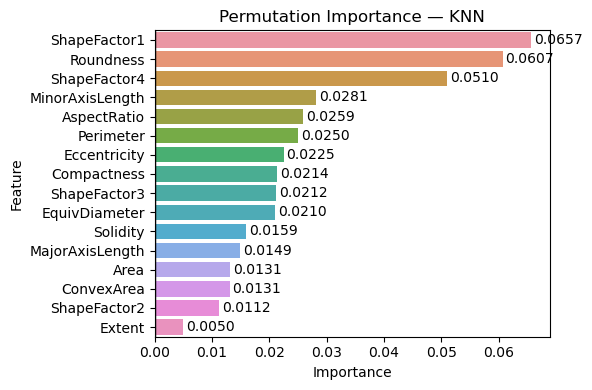


Permutation importance: SVM (START)
Permutation importance: SVM (DONE)

Permutation importance: SVM


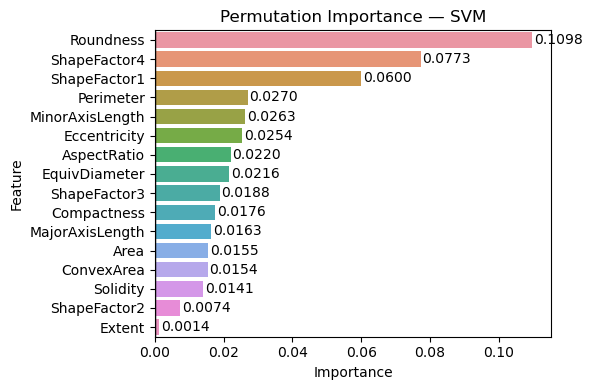


Permutation importance: GaussianNB (START)
Permutation importance: GaussianNB (DONE)

Permutation importance: GaussianNB


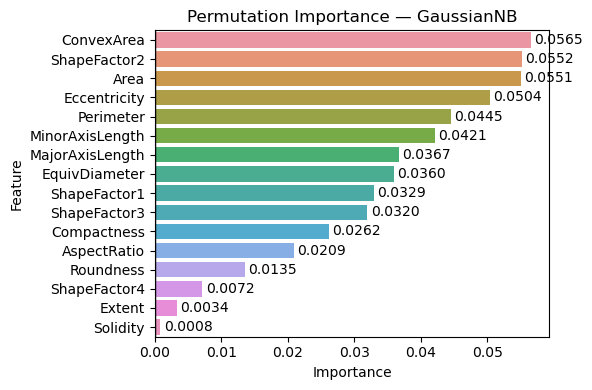

In [10]:
# permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
def perm_imp(model, X, y, n_repeats=20, random_state=42):
    r = permutation_importance(model, X, y, n_repeats=n_repeats,
                               random_state=random_state, n_jobs=-1)
    return r.importances_mean

for name, model in fitted_models.items():
    print(f"\nPermutation importance: {name} (START)")
    imp = perm_imp(model, X_test, y_test, n_repeats=5)  # test
    print(f"Permutation importance: {name} (DONE)")
    
    print(f"\nPermutation importance: {name}")

    imp = perm_imp(model, X_test, y_test)
    df = (pd.DataFrame({"Feature": feature_names, "Importance": imp})
            .sort_values("Importance", ascending=False))

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=df, x="Importance", y="Feature")
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title(f"Permutation Importance — {name}")


    for i, v in enumerate(df["Importance"].values):
        ax.text(v + (0.0005 if v >= 0 else -0.0005),
                i, f"{v:.4f}", va="center",
                ha=("left" if v >= 0 else "right"))
    plt.tight_layout()
    plt.show()


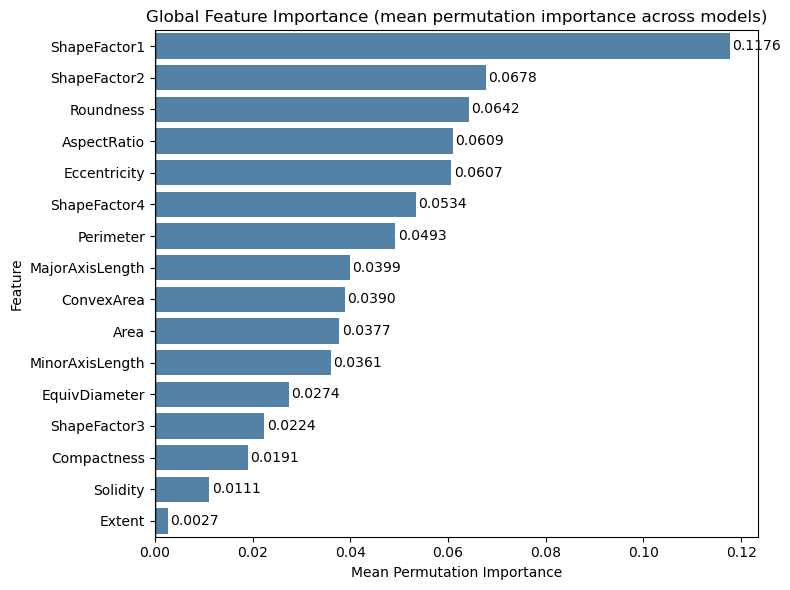

,GlobalImportance,StdAcrossModels
ShapeFactor1,0.117614,0.130328
ShapeFactor2,0.067777,0.089024
Roundness,0.064208,0.039712
AspectRatio,0.060945,0.076067
Eccentricity,0.060706,0.057256
ShapeFactor4,0.053358,0.033271
Perimeter,0.049250,0.035245
MajorAxisLength,0.039854,0.035873
ConvexArea,0.038963,0.029209
Area,0.037742,0.027510


In [17]:
#global feature importance (across all models)
def perm_imp(model, X, y, scoring="accuracy", n_repeats=20, random_state=42):
    r = permutation_importance(
        model, X, y,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=-1
    )
    return r.importances_mean

# collect permutation importance from all models
imp_dict = {}
for name, model in fitted_models.items():
    imp_dict[name] = perm_imp(model, X_test, y_test)

# build global importance (mean across models)
imp_df = pd.DataFrame(imp_dict, index=feature_names)  # rows=features, cols=models
global_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "GlobalImportance": imp_df.mean(axis=1),
        "StdAcrossModels": imp_df.std(axis=1)
    })
    .sort_values("GlobalImportance", ascending=False)
)

# plot global feature importance
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=global_df,
    x="GlobalImportance",
    y="Feature",
    color="steelblue"
)
ax.axvline(0, color="black", linewidth=1)
ax.set_title("Global Feature Importance (mean permutation importance across models)")
ax.set_xlabel("Mean Permutation Importance")

# annotate values
for i, v in enumerate(global_df["GlobalImportance"].values):
    ax.text(
        v + (0.0005 if v >= 0 else -0.0005),
        i,
        f"{v:.4f}",
        va="center",
        ha=("left" if v >= 0 else "right")
    )

plt.tight_layout()
plt.show()

global_df=global_df.drop(columns=["Feature"])
global_df.head(10)


<Figure size 800x600 with 0 Axes>

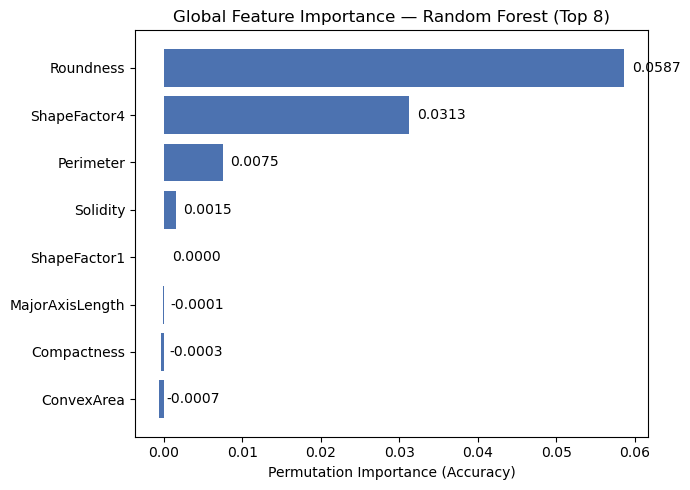

In [20]:
# ===== Pretty Global Feature Importance: Random Forest =====
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize=(8, 6))
# 1) train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

# 2) permutation importance using ACCURACY
rf_imp = permutation_importance(
    rf,
    X_test,
    y_test,
    scoring="accuracy",   # ← 关键：用 accuracy
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

rf_df = (
    pd.DataFrame({
        "GlobalImportance": rf_imp.importances_mean,
        "StdAcrossModels": rf_imp.importances_std
    }, index=feature_names)
    .sort_values("GlobalImportance", ascending=False)
)

rf_plot = rf_df.sort_values("GlobalImportance", ascending=False).head(8)

plt.figure(figsize=(7, 5))

plt.barh(
    rf_plot.index[::-1],   
    rf_plot["GlobalImportance"][::-1],
    color="#4C72B0"
)

plt.xlabel("Permutation Importance (Accuracy)")
plt.title("Global Feature Importance — Random Forest (Top 8)")

for i, v in enumerate(rf_plot["GlobalImportance"][::-1].values):
    plt.text(v + 0.001, i, f"{v:.4f}", va="center")

plt.tight_layout()
plt.show()